# Sentiment Analysis of Drug Review


## Dataset

<a href='https://archive.ics.uci.edu/ml/machine-learning-databases/00462/'Drug Review Dataset (Drugs.com) Data Set ></a> 

El dataset proporciona comentarios de pacientes sobre medicamentos específicos y una calificación (de 1 a 10), que refleja la satisfacción general del paciente respecto a ese fármaco. Dichos comentarios han sido tomados de la página web de drugs.com. 

Para cada comentario, también se incluyen otros campos como la condición (enfermedad) para la que se administra el fármaco, fecha y el número de pacientes que encontraron este comentario útil. 


Cargamos las librerías Python necesarias para el proyecto: 

In [0]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

El primer paso tenemos que montar nuestra unidad de Google Drive: 



In [4]:
from google.colab import drive
drive.mount("/content/drive/")
!ls 'drive/My Drive/Colab Notebooks/SA/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
1_baselineSA_airline.ipynb  isol		 Vectorizacion.ipynb
1_baselineSA_drugs.ipynb    movie_data		 WordEmbeddings.ipynb
1_lexicon_baseline.ipynb    Normalization.ipynb
drugsCom_raw		    Stopwords.ipynb


![texto alternativo](https://)Cargamos el training y test. 



In [7]:
data_train = "drive/My Drive/Colab Notebooks/SA/drugsCom_raw/drugsComTrain_raw.tsv"
drug_reviews_train = pd.read_csv(data_train,sep='\t')

#Cargamos también el test dataset
data_test = "drive/My Drive/Colab Notebooks/SA/drugsCom_raw/drugsComTest_raw.tsv"
drug_reviews_test = pd.read_csv(data_test,sep='\t')

#Mostramos los primeros registros del training
print('Training dataset', len(drug_reviews_train))
drug_reviews_train.head()

#print('Test dataset', len(drug_reviews_test))
#drug_reviews_test.head()


Training dataset 161297
Test dataset 53766


En los siguientes gráficos, podemos  ver la distribución de comentarios por grado de satisfacción, tanto en training como en test. Ambos dataset muestran distribuciones casi ídenticas, donde las clases con mayor número de comentarios son la 1, 8, 9 y 10. 


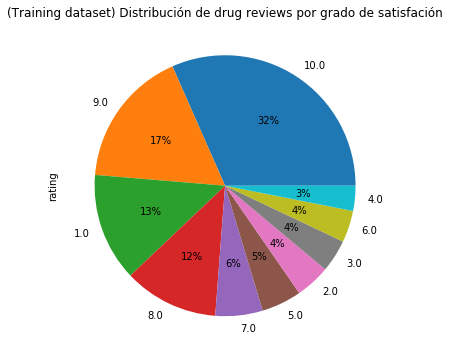

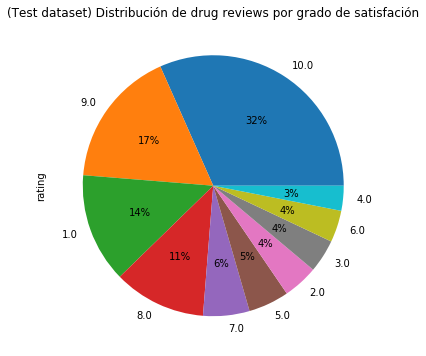

In [8]:
plot_size = plt.rcParams["figure.figsize"] 
#print(plot_size[0]) 
#print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

drug_reviews_train.rating.value_counts().plot(kind='pie', autopct='%1.0f%%',title='(Training dataset) Distribución de drug reviews por grado de satisfación')
plt.show()

drug_reviews_test.rating.value_counts().plot(kind='pie', autopct='%1.0f%%',title='(Test dataset) Distribución de drug reviews por grado de satisfación')
plt.show()

#drugs_all = pd.concat([drug_reviews_train, drug_reviews_test])
#drugs_all.rating.value_counts().plot(kind='pie', autopct='%1.0f%%',title='Distribución de drug reviews por grado de satisfación')
#plt.show()



Podemos ignorar la mayoría de los campos, guardando únicamente los textos y sus etiquetas (clases), que luego usaremos para entrenar y evaluar.



In [9]:
#guardamos textos y etiquetas
X_train = drug_reviews_train.iloc[:, 3].values
Y_train = drug_reviews_train.iloc[:, 4].values

X_test = drug_reviews_test.iloc[:, 3].values
Y_test = drug_reviews_test.iloc[:, 4].values

print('training and test loaded')

training and test loaded


## Primer paso: Limpiar los textos

Los tweets suelen contener muchos signos de puntuación y slang. Necesitamos limpiar nuestros tweets antes de que puedan usarse para entrenar el modelo de aprendizaje automático. Una forma de hacerlo es utilizar **expresiones regulares**.



In [0]:

def cleaning(texts):
  cleaned_texts=[]
  for text in texts:
    
      cleaned_text=text 

       # Remove all the special characters
      cleaned_text = re.sub(r'\W', ' ', str(cleaned_text))

      # Remove all numbers
      cleaned_text= re.sub(r'\d+', ' ', cleaned_text)

      # remove all single characters
      cleaned_text= re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned_text)

      # Remove single characters from the start
      cleaned_text = re.sub(r'\^[a-zA-Z]\s+', ' ', cleaned_text) 

      # Substituting multiple spaces with single space
      cleaned_text = re.sub(r'\s+', ' ', cleaned_text, flags=re.I)

      # Removing prefixed 'b'
      cleaned_text = re.sub(r'^b\s+', '', cleaned_text)

      # Converting to Lowercase
      cleaned_text = cleaned_text.lower()

      cleaned_text = cleaned_text.strip()

      cleaned_texts.append(cleaned_text)
  return cleaned_texts



In [11]:


for index,text in enumerate(X_train):
  if index in range(5) :
      print(text)
  if index>=6:
    break


print('cleaning.... puede tomar unos minutos')
X_train=cleaning(X_train)
X_test=cleaning(X_test)

print()
print('AFTER CLEANING...')
for index,text in enumerate(X_train):
  if index in range(5) :
      print(text)
  if index>=6:
    break

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective."
"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene,

<br>

Otra técnicas que se suelen utilizar para limpiar los textos:

*   Borrar **stopwords** (palabras sin contenido semántico): pronombres, determinantes, etc.
*   **Lematización** (sustituir sus palabras por su lema) o **stemming** (sustituir una palabra por su raíz).

Librerías como nltk (https://www.nltk.org/) or Spacy (https://spacy.io/) dan soporte a estas funcionalidades. 





## Segundo Paso - Vectorización.

Representación de los textos usando el modelo TF-IDF

In [12]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
print('vectorización.... puede tomar unos minutos')
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(X_train).toarray()
#Representamos también los textos conjunto de evaluación
X_test = vectorizer.transform(X_test).toarray()
print('textos representados...')

# Tercer paso: entrenar un algoritmo de aprendizaje automático



Entrenamos un clasificador, en concreto, SVM

In [0]:
print('training... puede tomar unos minutos')

from sklearn.svm import SVC
model = SVC(kernel='linear')

model.fit(X_train, Y_train)
print('modelo entrenado')


training... puede tomar unos minutos


# Cuarto paso: evaluación

Aplicamos el modelos de predición sobre el conjunto de evaluación y calculamos resultados (precisiónn, recall, F1). 


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

predictions = model.predict(X_test)

print(confusion_matrix(Y_test,predictions))
print(classification_report(Y_test,predictions))
print(accuracy_score(Y_test, predictions))


[[1694  127   49]
 [ 276  297   41]
 [ 126   49  269]]
              precision    recall  f1-score   support

    negative       0.81      0.91      0.85      1870
     neutral       0.63      0.48      0.55       614
    positive       0.75      0.61      0.67       444

    accuracy                           0.77      2928
   macro avg       0.73      0.67      0.69      2928
weighted avg       0.76      0.77      0.76      2928

0.7718579234972678
